In [10]:
import numpy as np
import pandas as pd
import matplotlib as ml
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier as adb

### Adaboost classifier from scratch

In [2]:
class AdaboostClassifier():
  def __init__(self,base_estimator=DecisionTreeClassifier(max_depth=1,max_leaf_nodes=2),n_estimators=50):
    self.base_estimator = base_estimator
    self.n_estimators = n_estimators
    # Factors that work under the hood
    # Stumps (Models)
    self.stumps = None
    # Alpha values
    self.stump_weights = None
    # Errors per estimator
    self.errors = None
    # Initializing weights
    self.sample_weights = None
  def fit(self,trainx,trainy):
    N = trainx.shape[0]

    # Initialize the factors
    # Stumps (Models)
    self.stumps = np.zeros(shape=self.n_estimators,dtype=object)
    # Alpha values
    self.stump_weights = np.zeros(shape=self.n_estimators)
    # Errors per estimator
    self.errors = np.zeros(shape=self.n_estimators)
    # Initializing weights
    self.sample_weights = np.zeros(shape=(self.n_estimators,N))

    # Initialize weight for run 1(then automated updation)
    self.sample_weights[0] = (np.ones(shape=N))/N

    # Main procedure(iterate over all n_estimators)
    for i in range(self.n_estimators):
      current_weight = self.sample_weights[i]
      stump = self.base_estimator
      stump.fit(trainx,trainy,sample_weight = current_weight)
      # Calculate error and alpha values
      stump_pred = stump.predict(trainx)
      err = current_weight[(stump_pred != trainy)].sum()
      stump_weight = np.log((1 - err)/err)/2
      # Update
      new_sample_weights = (
          current_weight*np.exp(-stump_weight*trainy*stump_pred)
      )
      # Normalize alpha
      new_sample_weights /= new_sample_weights.sum()

      # Condition to check if next iteration is last
      # If no, update sample_weights (initialized weights)
      if i+1 < self.n_estimators:
        self.sample_weights[i+1] = new_sample_weights

      # Append values we just found out to the factors' arrays
      # Stumps (Models)
      self.stumps[i] = stump
      # Alpha values
      self.stump_weights[i] = stump_weight
      # Errors per estimator
      self.errors[i] = err
    return self
  def predict(self,testx):
    stump_preds = np.array([stump.predict(testx) for stump in self.stumps])
    # Define output and sign related to it
    # Note : Classes are of two types here = -1 and +1
    return np.sign(np.dot(self.stump_weights,stump_preds))

### Checking how it works on a sample dataset
#### Dataset used : play_tennis.csv

In [3]:
tennis = pd.read_csv('/content/drive/My Drive/datasets_89775_207354_play_tennis (1).csv')
tennis.drop(columns=['day'],inplace=True)
tennis['play'] = tennis['play'].replace('Yes',1)
tennis['play'] = tennis['play'].replace('No',-1)
tennis.head(10)

,outlook,temp,humidity,wind,play
0,Sunny,Hot,High,Weak,-1
1,Sunny,Hot,High,Strong,-1
2,Overcast,Hot,High,Weak,1
3,Rain,Mild,High,Weak,1
4,Rain,Cool,Normal,Weak,1
5,Rain,Cool,Normal,Strong,-1
6,Overcast,Cool,Normal,Strong,1
7,Sunny,Mild,High,Weak,-1
8,Sunny,Cool,Normal,Weak,1
9,Rain,Mild,Normal,Weak,1


Label encoding

In [4]:
le = LabelEncoder()
tennis['outlook'] = le.fit_transform(tennis['outlook'])
tennis['temp'] = le.fit_transform(tennis['temp'])
tennis['humidity'] = le.fit_transform(tennis['humidity'])
tennis['wind'] = le.fit_transform(tennis['wind'])
tennis

,outlook,temp,humidity,wind,play
0,2,1,0,1,-1
1,2,1,0,0,-1
2,0,1,0,1,1
3,1,2,0,1,1
4,1,0,1,1,1
5,1,0,1,0,-1
6,0,0,1,0,1
7,2,2,0,1,-1
8,2,0,1,1,1
9,1,2,1,1,1


In [5]:
X,Y = tennis.iloc[:,:-1],tennis.iloc[:,-1].values
trainx,testx,trainy,testy = train_test_split(X,Y,test_size=0.2,random_state=0)

In [6]:
adb = AdaboostClassifier()
adb.fit(trainx,trainy)

In [7]:
query_point = [[2,1,0,1]]
adb.predict(query_point)[0]

-1.0

### Plotting the decision boundaries of the AdaboostClassifier algorithm
This will be a comparative plot between sklearn's AdaboostClassifier() and the one created above from scratch.

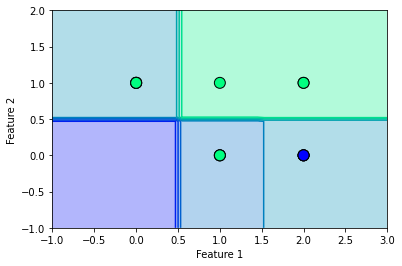

In [22]:
X_T,Y_T = tennis.iloc[:,1:3].values,tennis.iloc[:,-1].values
# Plotting function
def plot_adaboost_boundary(clf=None,X=X_T,Y=Y_T,ax=None):
  plt.cla()
  x1_arr = np.linspace(start=X[:,0].min()-1,stop=X[:,0].max()+1)
  x2_arr = np.linspace(start=X[:,1].min()-1,stop=X[:,1].max()+1)
  XX,YY = np.meshgrid(x1_arr,x2_arr)
  test_data = np.array([XX.ravel(),YY.ravel()]).T

  # Checking availability of attributes
  if hasattr(clf,'decision_function'):
    z = (clf.decision_function(test_data)).reshape(XX.shape)
  elif hasattr(clf,'predict_proba'):
    z = (clf.predict_proba(test_data)).reshape(XX.shape)
  else:
    z = (clf.predict(test_data)).reshape(XX.shape)
  
  # Plotting
  colors = ListedColormap(('blue','green'))
  if ax is None:
    ax = plt.gca()
  ax.contourf(XX,YY,z,alpha = 0.3,cmap='winter')
  ax.contour(XX,YY,z,cmap='winter')
  ax.scatter(X[:,0],X[:,1],c=Y_T,cmap='winter',edgecolors='black',s=120)
  ax.set_xlabel("Feature 1")
  ax.set_ylabel("Feature 2")

# Testing
# sklearn's
adab = adb(n_estimators=50)
adab.fit(X_T,Y_T)
plot_adaboost_boundary(clf=adab)

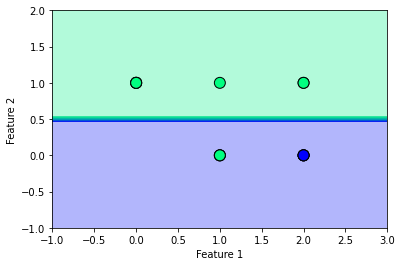

In [23]:
# From scratch
adabst = AdaboostClassifier(n_estimators=50)
adabst.fit(X_T,Y_T)
plot_adaboost_boundary(clf=adabst)